In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Read in data

In [2]:
filesample = 'Sample_Program_Service_Data.csv'
filefull = 'Full990Efile+Operational+Data+2009+to+2015.csv'

#datasample = pd.read_csv(filesample, encoding='cp1252')

datafull = pd.read_csv(filefull, encoding='cp1252', 
                       usecols=['EIN','STATE','FISYR','TOTALREVCURRENT','TOTALEXPCURRENT', 'FORMTYPE', 'NteeFinal',
                               'TOTEMPLOYEE', 'TOTVOLUNTEERS', 'REVLESSEXPCURRENT'])
datafull.head()

,EIN,FISYR,STATE,FORMTYPE,NteeFinal,TOTEMPLOYEE,TOTVOLUNTEERS,TOTALREVCURRENT,TOTALEXPCURRENT,REVLESSEXPCURRENT
0,10024645,2009,ME,990,A69,3.0,32.0,568558.0,457531.0,111027.0
1,10078060,2009,ME,990,E22,1034.0,83.0,81381144.0,80826802.0,554342.0
2,10095329,2009,ME,990EZ,Y40,NaN,NaN,20333.0,34191.0,-13858.0
3,10095414,2009,ME,990,Y41,3.0,NaN,164706.0,234079.0,-69373.0
4,10130427,2009,ME,990,E22,371.0,85.0,42460089.0,39356059.0,3104030.0


In [3]:
datafull.index.names

FrozenList([None])

In [4]:
datafull.shape

(1518095, 10)

In [5]:
datafull.columns

Index(['EIN', 'FISYR', 'STATE', 'FORMTYPE', 'NteeFinal', 'TOTEMPLOYEE',
       'TOTVOLUNTEERS', 'TOTALREVCURRENT', 'TOTALEXPCURRENT',
       'REVLESSEXPCURRENT'],
      dtype='object')

# Indexing

Compute net income, obtain year-on-year index. Divide over all relevant charities in State. This ratio indicates relative volatility compared to the broad-spectrum charities on market in state.

Treat missing values in PREV_NIT as NIT

In [6]:
def get_ind_indices(curr_criteria):
    data = datafull.query('(FISYR > 2009) & (FISYR < 2015)')
    data = data[data.FORMTYPE=='990']
    #data.set_index(['EIN', 'FISYR'], inplace=True)
    #prev_criteria = data.groupby(level=0)[curr_criteria].shift(1)
    data.set_index(['EIN',  'FISYR'], inplace=True)
    data['PREV_'+curr_criteria] = data.groupby(level=0)[curr_criteria].shift(1)

    
    data['IND'] = data[curr_criteria]/data['PREV_'+curr_criteria]
    data.IND.replace(np.inf, np.nan, inplace=True)
    data.IND.replace(-1*np.inf, np.nan, inplace=True)
    data.IND.fillna(1, inplace=True)
    return data

In [7]:
eins = get_ind_indices('REVLESSEXPCURRENT')
eins.head()

,,STATE,FORMTYPE,NteeFinal,TOTEMPLOYEE,TOTVOLUNTEERS,TOTALREVCURRENT,TOTALEXPCURRENT,REVLESSEXPCURRENT,PREV_REVLESSEXPCURRENT,IND
EIN,FISYR,,,,,,,,,,
10360501,2010,ME,990,F0122,0.0,0.0,41637.0,1655148.0,-1613511.0,NaN,1.0
10521321,2010,ME,990,P75,0.0,0.0,0.0,0.0,0.0,NaN,1.0
20705535,2010,MA,990,V24,5.0,0.0,490537.0,737692.0,-247155.0,NaN,1.0
60867533,2010,MD,990,S03,0.0,0.0,299323.0,554207.0,-254884.0,NaN,1.0
111773894,2010,NY,990,J40,14.0,0.0,994557.0,2050880.0,-1056323.0,NaN,1.0


In [8]:
def get_br_indices(curr_criteria):
    broad = datafull.query('FISYR > 2009 & FISYR < 2015')
    broad = broad[broad.FORMTYPE=='990']
    #broad.index.names
    
    #broad.set_index(['STATE', 'FISYR'], inplace=True)
    #broad.index.names
    
    br_curr = broad.groupby(['STATE','FISYR'])[curr_criteria].sum()
    br_prev = br_curr.groupby(level=[0]).shift(1)
        
    new = pd.DataFrame()
    new['BR_IND'] = br_curr/br_prev
    new.BR_IND.replace(np.inf, np.nan, inplace=True)
    new.BR_IND.replace(-1*np.inf, np.nan, inplace=True)
    new.BR_IND.fillna(1, inplace=True)
    return new

In [10]:
br = get_br_indices('REVLESSEXPCURRENT')
br.head()

BR_IND
STATE FISYR           
AE    2010    1.000000
      2011   -0.193283
      2012   -1.322907
      2013  -18.814302
      2014   -0.931216

In [11]:
def get_all(ind, br):
    all = pd.merge(ind.reset_index(), br.reset_index(), how='inner', on=['STATE','FISYR']).set_index(['EIN','FISYR'])
    #all = pd.merge(ind, br)
    return all

In [13]:
all = get_all(eins, br)
all.head()

,,STATE,FORMTYPE,NteeFinal,TOTEMPLOYEE,TOTVOLUNTEERS,TOTALREVCURRENT,TOTALEXPCURRENT,REVLESSEXPCURRENT,PREV_REVLESSEXPCURRENT,IND,BR_IND
EIN,FISYR,,,,,,,,,,,
10360501,2010,ME,990,F0122,0.0,0.0,41637.0,1655148.0,-1613511.0,NaN,1.0,1.0
10521321,2010,ME,990,P75,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0
10018930,2010,ME,990,W30,7.0,0.0,806362.0,783045.0,23317.0,NaN,1.0,1.0
10029480,2010,ME,990,S41,4.0,10.0,210379.0,226794.0,-16415.0,NaN,1.0,1.0
10043285,2010,ME,990,S41,6.0,0.0,605748.0,605515.0,233.0,NaN,1.0,1.0


In [14]:
all.index.names

FrozenList(['EIN', 'FISYR'])

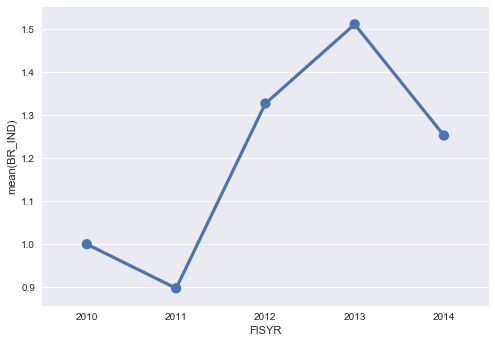

In [15]:
plotdf_all = all.reset_index()
plotdf_all.index.names
sns.pointplot(x="FISYR", y="BR_IND",data=plotdf_all)
plt.show()
